In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import forward
import torch
import os
import pickle


# SimPEG imports
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh


# SBI imports
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis


# SimPeg Forward Model

## Forward Simulation - Textbook example

In [2]:
# Define the 'a' spacing for Schlumberger array measurements for each reading
number_of_measurements=19
a_b_electrode_separations = np.logspace(0.1, 3, number_of_measurements)
m_n_electrode_separations = 0.01 * a_b_electrode_separations 

source_list = []  # create empty array for sources to live

for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations):


    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-ab, 0.0, 0.0]
    B_location = np.r_[ab, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-mn, 0.0, 0.0]
    N_location = np.r_[mn, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

electrode_separations = 0.5 * np.sqrt(
    np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
)

In [3]:
# Define layer thicknesses.
layer_thicknesses = np.r_[5.0, 10.0]

# Define layer resistivities.
model = np.r_[500, 200, 50]

# Define mapping from model to 1D layers.
model_map = maps.IdentityMap(nP=len(model))

In [4]:
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

# Predict data for a given model
dpred = simulation.dpred(model)

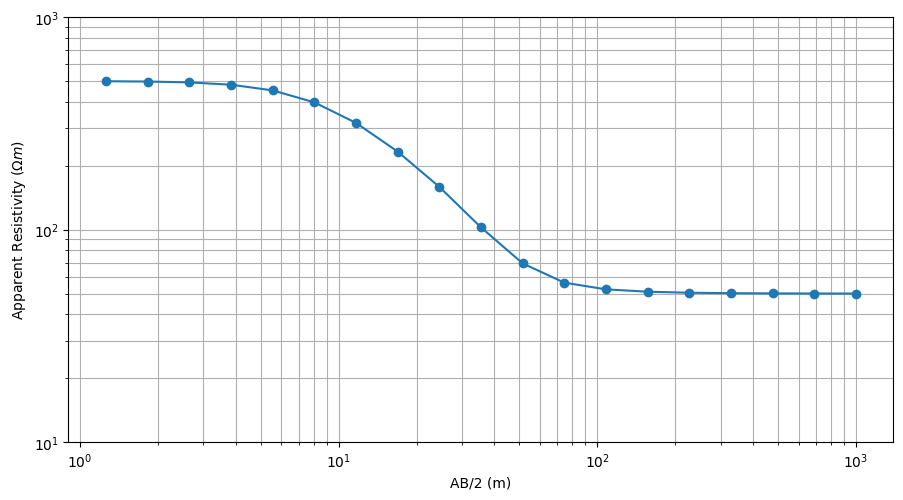

In [5]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog( a_b_electrode_separations, dpred, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_ylim([10, 1000])
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()


# Inversion of Sounding Data - Textbook example
## SimPEG - Least Squares 1D Inversion

In [6]:
std = 0.02 * np.abs(dpred)
data_object = data.Data(survey, dobs=dpred, standard_deviation=std)

In [7]:
# Define layer thickness
layer_thicknesses =  np.r_[5,10]
#layer_thicknesses =  np.logspace(0, 0.3, 10)
#layer_thicknesses =  np.linspace(1, 15, 10)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "0")

In [8]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer. - here each layer gets the same resistivity assigned
starting_model = np.log(2e2 * np.ones((len(layer_thicknesses) + 1)))  

# Define mapping from model to active cells.
model_map = maps.IdentityMap(nP=len(starting_model)) * maps.ExpMap()

In [9]:
# Define the physics of the problem using the Simulation1DLayers class.
simulation = dc.simulation_1d.Simulation1DLayers(
    survey=survey,
    rhoMap=model_map,
    thicknesses=layer_thicknesses,
)

In [10]:
# Use L2 norm for data misfit of the weighted residual between observed and predicted
l2_data_misfit = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.WeightedLeastSquares(
    mesh, alpha_s=1.0, alpha_x=1.0, reference_model=starting_model
)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=20)


# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(l2_data_misfit, reg, opt)

In [11]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off parameter value.
beta_schedule = directives.BetaSchedule(coolingFactor=5.0, coolingRate=3.0)

# Apply and update sensitivity weighting as the model updates
update_sensitivity_weights = directives.UpdateSensitivityWeights()

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    update_sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
]

In [12]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayers problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.89e+04  9.28e+04  0.00e+00  9.28e+04    2.28e+05      0              
   1  2.89e+04  3.30e+04  7.75e-01  5.54e+04    2.24e+04      0              
   2  2.89e+04  3.71e+04  6.05e-01  5.45e+04    4.67e+03      0              
   3  5.78e+03  3.60e+04  6.41e-01  3.97e+04    8.07e+04      0              
   4  5.78e+03  9.94e+03  2.84e+00  2.63e+04    6.36e+03      0              
   5  5.78e+03  1.15e+04  2.54e+00  2.62e+04    1.98e+03      0              
   6  1.16e+03  1.08e+04  2.65e+00

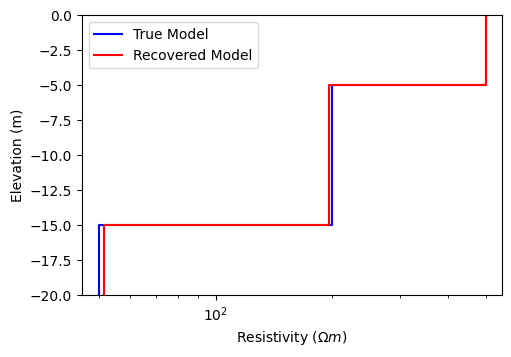

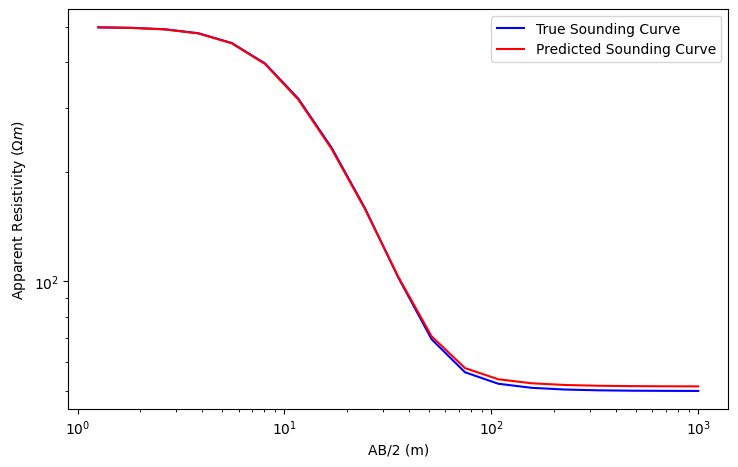

In [13]:
# Define true model and layer thicknesses
true_model = np.r_[500, 200, 50]
true_thickness = np.r_[5.0, 10.0]

# Plot true model and recovered model
fig = plt.figure(figsize=(6, 4))
x_min = np.min([np.min(model_map * recovered_model), np.min(model)])
x_max = np.max([np.max(model_map * recovered_model), np.max(model)])

ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(true_thickness, true_model, ax=ax1, plot_elevation=True, color="b")
plot_1d_layer_model(
    layer_thicknesses,
    model_map * recovered_model,
    ax=ax1,
    plot_elevation=True,
    color="r",
)
ax1.set_xlabel(r"Resistivity ($\Omega m$)")
ax1.set_xlim(0.9 * x_min, 1.1 * x_max)
ax1.set_ylim(-20, 0)
ax1.legend(["True Model", "Recovered Model"])

# Plot the true and apparent resistivities on a sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(electrode_separations, dpred, "b")
ax1.loglog(electrode_separations, inv_prob.dpred, "r")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()

## SBI for Inversion - Textbook example 
#### Attempt to fix the thicknesses of the model - assume they are known and fixed and only infer the resistivities

In [34]:
# Note parameters are composed of resistivities and thicknesses - in that order. First resistivities then thicknesses
def dc_forward(params, survey=survey):
    
    # Split params into resistivities and thicknesses
    param_length = len(params)
    number_of_layers = int((param_length+1)/2)
    # First half of parameters is resistivities
    resistivities = params[:number_of_layers]
    # Second half of parameters are thicknesses
    thicknesses = params[number_of_layers:]
    
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

In [53]:
# Note parameters are composed of resistivities and thicknesses - in that order. First resistivities then thicknesses
def dc_forward_resistivities(params, survey=survey):

    # First half of parameters is resistivities
    resistivities = params
    thicknesses = np.r_[5,10]
    
    # Define mapping from model to 1D layers.
    model_map = maps.IdentityMap(nP=len(resistivities))
    simulation = dc.simulation_1d.Simulation1DLayers(
        survey=survey,
        rhoMap=model_map,
        thicknesses=thicknesses,
    )
    
    # Predict data for a given model
    pred = simulation.dpred(resistivities)
    return pred

In [36]:
num_dim = 3
prior_min = torch.as_tensor([0,0,0])
prior_max = torch.as_tensor([5000,5000,5000])

prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))

simulator, prior = prepare_for_sbi(dc_forward_resistivities, prior)

In [37]:
inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [38]:
inference = inference.append_simulations(theta, x)

In [39]:
density_estimator = inference.train()

 Neural network successfully converged after 132 epochs.

In [40]:
posterior = inference.build_posterior(density_estimator)

In [41]:
posterior_samples = posterior.sample((10000,), x=dpred)


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

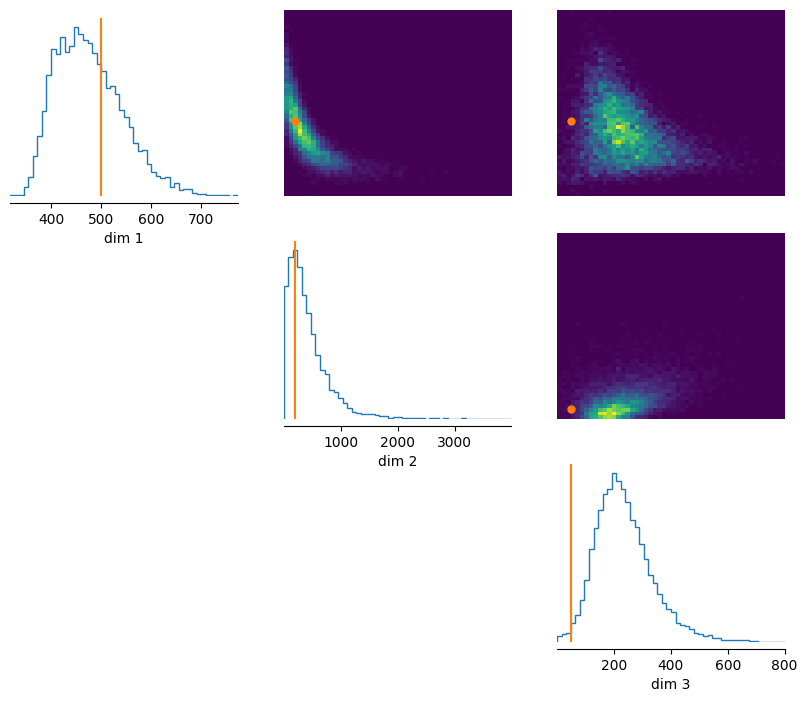

In [42]:
# plot Posterior samples
_ = analysis.pairplot(posterior_samples,points= torch.tensor([500,200, 50]), figsize=(10,8))

ValueError: x and y must have same first dimension, but have shapes (100,) and (19,)

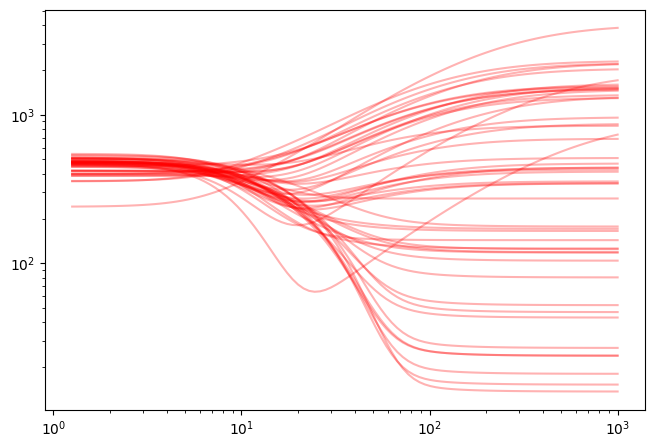

In [81]:
# Plot individual sounding curves from the derived posterior samples
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])


for i in range(50):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward_resistivities(np.array(posterior_sample))
    ax1.loglog(electrode_separations, app_res, "r", alpha=0.3)

ax1.loglog(electrode_separations, dpred, "b", label="True Sounding Curve")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend()
plt.show()


### Plot for the 5 parameter model using dc_resistivity as forward with attempt to fix the thicknesses to 5 and 10 via very narrow Uniform Box distribution

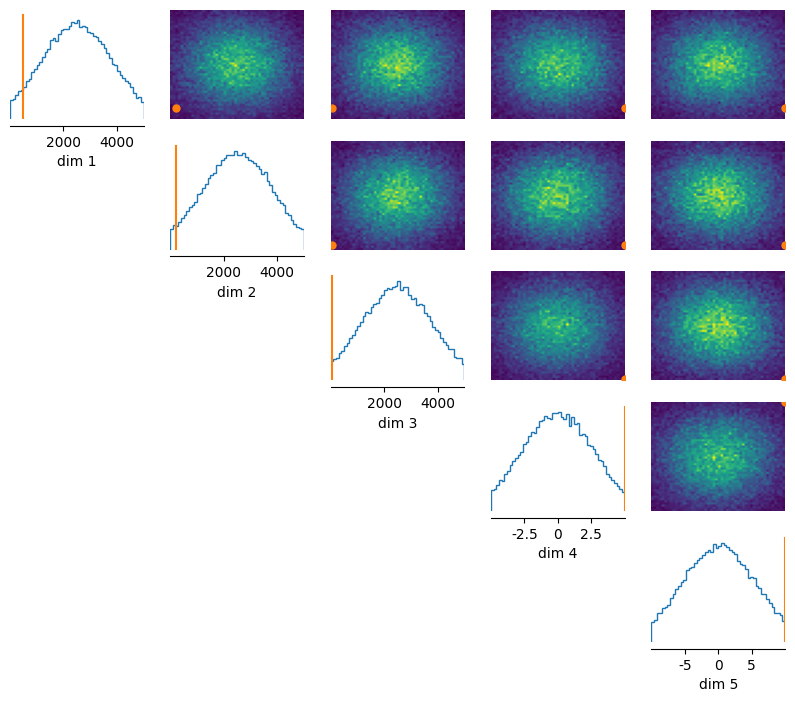

In [32]:
# plot Posterior samples
_ = analysis.pairplot(posterior_samples,points= torch.tensor([500,200, 50, 5, 10]), figsize=(10,8))

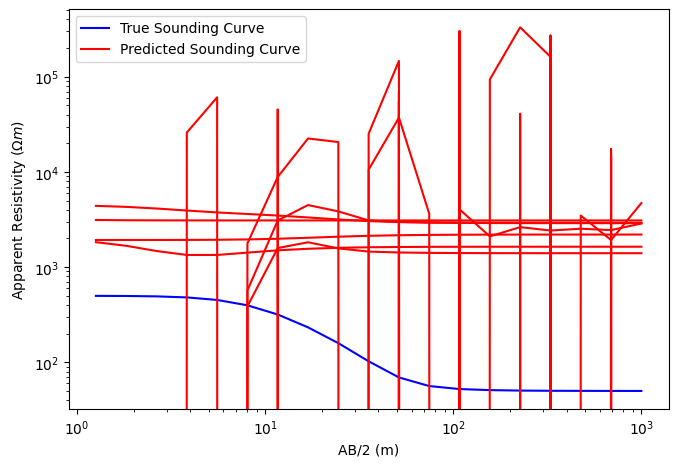

In [27]:
# Plot individual sounding curves from the derived posterior samples
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(electrode_separations, dpred, "b")

for i in range(10):
    posterior_sample = posterior_samples[i]
    app_res = dc_forward(np.array(posterior_sample))
    ax1.loglog(electrode_separations, app_res, "r")

ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()


#### From discussion with Guy after showing the plots

From the posterior check the sounding curves and see how they look like, might be that they all match the original sounding curves
100 parameters is not that much.
increase the number of measurements, currently only 19 measurements were taken - increase up to 50 or even 100
set the thicknesses fixed - assume you already know them and then only infer the resistivities


## Attempt to increase the amount of measurements taken for the initial sounding curves

#### Step 1 - Generate the sounding examples for 100 measurements



In [49]:
# Define the 'a' spacing for Schlumberger array measurements for each reading
number_of_measurements=100
a_b_electrode_separations = np.logspace(0.1, 3, number_of_measurements)
m_n_electrode_separations = 0.01 * a_b_electrode_separations 

source_list = []  # create empty array for sources to live

for ab, mn in zip(a_b_electrode_separations, m_n_electrode_separations):


    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = np.r_[-ab, 0.0, 0.0]
    B_location = np.r_[ab, 0.0, 0.0]

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_location = np.r_[-mn, 0.0, 0.0]
    N_location = np.r_[mn, 0.0, 0.0]

    # Create receivers list. Define as pole or dipole.
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Define the source properties and associated receivers
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
survey = dc.Survey(source_list)

electrode_separations = 0.5 * np.sqrt(
    np.sum((survey.locations_a - survey.locations_b) ** 2, axis=1)
)

In [50]:
# Define layer thicknesses.
layer_thicknesses = np.r_[5.0, 10.0]

# Define layer resistivities.
model = np.r_[500, 200, 50]
params = np.r_[model, layer_thicknesses]

dpred_100 = dc_forward(params, survey)


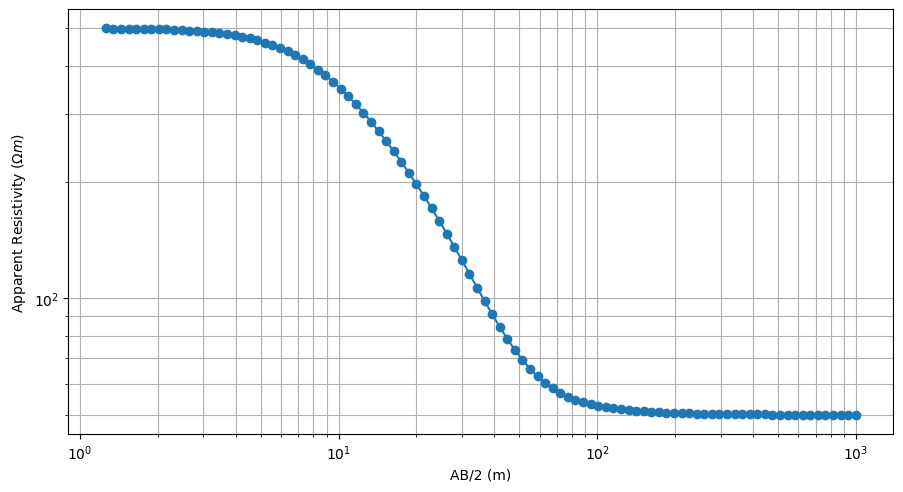

In [51]:
# Plot apparent resistivities on sounding curve# Plot apparent resistivities on sounding curve
fig = plt.figure(figsize=(11, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog( a_b_electrode_separations, dpred_100, marker='o', label="$50 \Omega m$) lower unit")
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
plt.grid(True, which="both", ls="-")
plt.show()


In [55]:
num_dim = 3
prior_min = torch.as_tensor([0, 0, 0 ])
prior_max = torch.as_tensor([5000, 5000, 5000 ])

prior = utils.BoxUniform(low=-prior_min * torch.ones(num_dim), high=prior_max * torch.ones(num_dim))


In [56]:
simulator, prior = prepare_for_sbi(dc_forward_resistivities, prior)
inference = SNPE(prior=prior, device="cpu", show_progress_bars=True)
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [58]:
with open("pickle/sbi_models/theta_10000_simulations.pkl", "wb") as input:
    pickle.dump(theta, input)
    
with open("pickle/sbi_models/x_10000_simulations.pkl", "wb") as input:
    pickle.dump(x, input)

In [60]:
inference = inference.append_simulations(theta, x)

In [61]:
density_estimator = inference.train()

 Neural network successfully converged after 92 epochs.

In [63]:
posterior = inference.build_posterior(density_estimator)
posterior_samples = posterior.sample((100000,), x=dpred_100)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

In [83]:
with open("pickle/sbi_models/posterior_10000_simulations_resistivities_only.pkl", "wb") as input:
    pickle.dump(posterior, input)
    

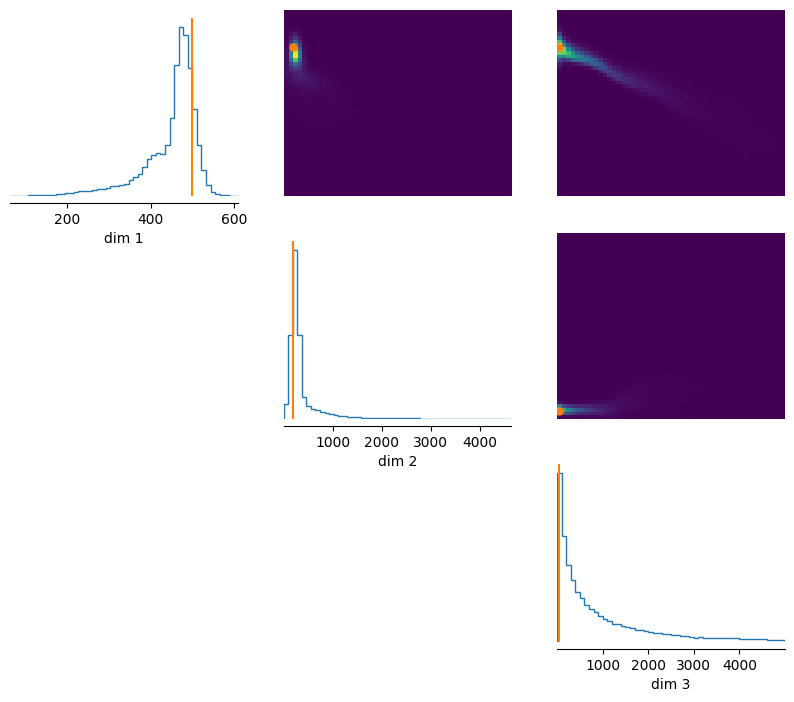

In [65]:
# plot Posterior samples
_ = analysis.pairplot(posterior_samples, points=torch.tensor([500, 200, 50]), figsize=(10, 8))

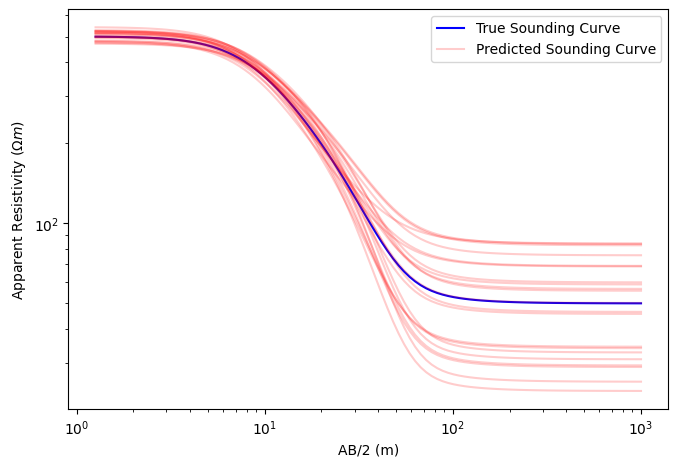

In [82]:
# Plot individual sounding curves from the derived posterior samples
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.8])
ax1.loglog(electrode_separations, dpred_100, "b")

num_good_samples = 0
apparent_resistivities = []
while num_good_samples <= 20:
    i = np.random.randint(100000)
    posterior_sample = posterior_samples[i]
    first_res = posterior_sample[0]
    second_res = posterior_sample[1]
    third_res = posterior_sample[2]
    if(450 <= first_res <= 550
        and 150 <= second_res <= 250
        and 10 <= third_res <= 100):
        num_good_samples += 1
        app_res = dc_forward_resistivities(np.array(posterior_sample))
        apparent_resistivities.append(app_res)
        ax1.loglog(electrode_separations, app_res, "r", alpha=0.2)

ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Apparent Resistivity ($\Omega m$)")
ax1.legend(["True Sounding Curve", "Predicted Sounding Curve"])
plt.show()


In [ ]:
# Less observations - e.g. 20 
# Try to make them evenly spaced np.linspace instead of logspace
# Try to limit in terms of std. 
# Heavy tails might come from too many observations - e.g. same for the penguine example